<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/gula_pasir_premium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f5d0532d430>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.gula_pasir_kualitas_premium.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


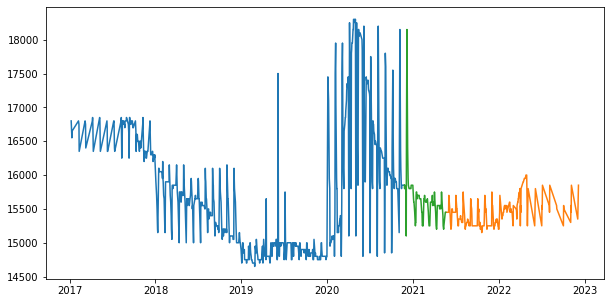

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_gulpas_premium_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 17s 60ms/step - loss: 0.2708 - mae: 0.4418 - mape: 87.8088 - val_loss: 0.0054 - val_mae: 0.0676 - val_mape: 53.3674
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1955 - mae: 0.3561 - mape: 66.6589 - val_loss: 0.0023 - val_mae: 0.0309 - val_mape: 50.2247
Epoch 3/30
44/44 [==============================] - 1s 18ms/step - loss: 0.1478 - mae: 0.3017 - mape: 65.4758 - val_loss: 0.0079 - val_mae: 0.0769 - val_mape: 101.0284
Epoch 4/30
44/44 [==============================] - 1s 18ms/step - loss: 0.1182 - mae: 0.2655 - mape: 67.4344 - val_loss: 0.0173 - val_mae: 0.1237 - val_mape: 146.5189
Epoch 5/30
44/44 [==============================] - 1s 18ms/step - loss: 0.0997 - mae: 0.2387 - mape: 69.4110 - val_loss: 0.0283 - val_mae: 0.1621 - val_mape: 183.7058
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0882 - mae: 0.2245 - mape: 73.5505 - val_loss: 0.0396 - val_mae: 0.1937 - val_mape: 21

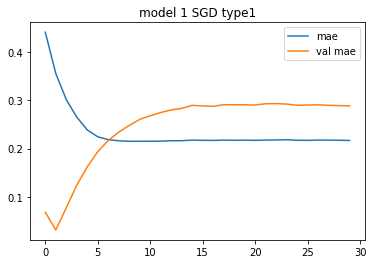

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
811.2962 5.273575 832.8100023414704


,date,actual,prediction
0,2021-05-20,15450,16365.494141
1,2021-05-21,15450,16363.739258
2,2021-05-24,15450,16357.814453
3,2021-05-25,15450,16355.094727
4,2021-05-27,15450,16347.329102
...,...,...,...
229,2022-11-02,15550,16279.367188
230,2022-11-03,15450,16276.490234
231,2022-11-04,15850,16274.066406
232,2022-12-01,15350,16272.064453


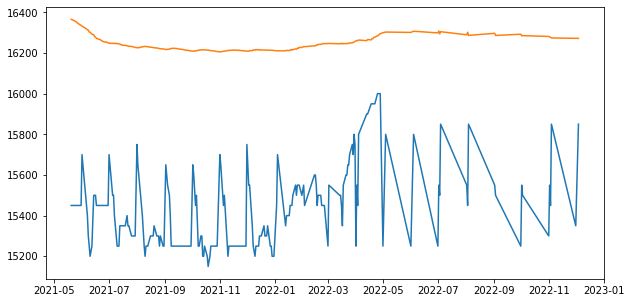

In [ ]:
prediction = forecast_predict(model, test_gulpas_premium_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_gulpas_premium = pd.DataFrame()
data_new_gulpas_premium['date'] = y_test
data_new_gulpas_premium['actual'] = x_test
data_new_gulpas_premium['prediction'] = data_result
data_new_gulpas_premium.to_csv('gulpas_premium_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_gulpas_premium.date, data_new_gulpas_premium.actual)
plt.plot(data_new_gulpas_premium.date, data_new_gulpas_premium.prediction)
data_new_gulpas_premium

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0432 - mae: 0.1532 - mape: 179105.9219 - val_loss: 0.0389 - val_mae: 0.1920 - val_mape: 212.7096
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0372 - mae: 0.1320 - mape: 289284.9688 - val_loss: 0.0343 - val_mae: 0.1795 - val_mape: 200.7114
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0345 - mae: 0.1259 - mape: 236021.3906 - val_loss: 0.0314 - val_mae: 0.1713 - val_mape: 192.7817
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0321 - mae: 0.1198 - mape: 176078.7031 - val_loss: 0.0283 - val_mae: 0.1618 - val_mape: 183.7048
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0299 - mae: 0.1135 - mape: 204852.9531 - val_loss: 0.0221 - val_mae: 0.1415 - val_mape: 164.1999
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0283 - mae: 0.1101 - mape: 186147.5938 - val_loss: 0.0178 -

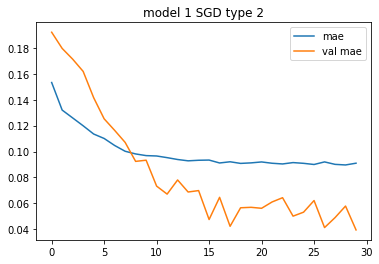

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
186.38142 1.2076056 228.7197982111518


,date,actual,prediction
0,2021-05-20,15450,16365.494141
1,2021-05-21,15450,16363.739258
2,2021-05-24,15450,16357.814453
3,2021-05-25,15450,16355.094727
4,2021-05-27,15450,16347.329102
...,...,...,...
229,2022-11-02,15550,16279.367188
230,2022-11-03,15450,16276.490234
231,2022-11-04,15850,16274.066406
232,2022-12-01,15350,16272.064453


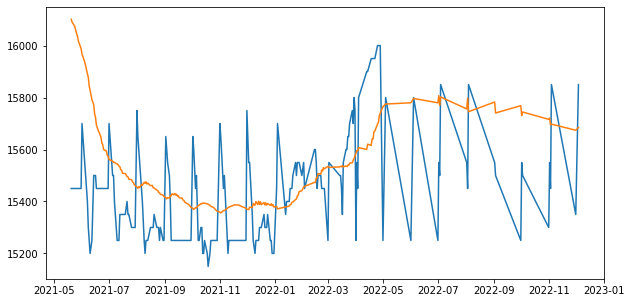

In [ ]:
win_size1 = 60
test_gulpas_premium_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_gulpas_premium_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_gulpas_premium_1 = pd.DataFrame()
data_new_gulpas_premium_1['actual'] = x_test
data_new_gulpas_premium_1['prediction'] = data_result_1
data_new_gulpas_premium_1.to_csv('gulpas_premium_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_premium_1.actual)
plt.plot(y_test, data_new_gulpas_premium_1.prediction)
data_new_gulpas_premium

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0339 - mae: 0.1166 - mape: 79.2609 - val_loss: 0.0035 - val_mae: 0.0433 - val_mape: 66.7058
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0336 - mae: 0.1228 - mape: 92.0325 - val_loss: 0.0039 - val_mae: 0.0467 - val_mape: 70.4860
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0335 - mae: 0.1218 - mape: 89.5060 - val_loss: 0.0037 - val_mae: 0.0448 - val_mape: 68.4198
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0335 - mae: 0.1219 - mape: 89.3447 - val_loss: 0.0040 - val_mae: 0.0482 - val_mape: 72.1171
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0334 - mae: 0.1212 - mape: 87.8687 - val_loss: 0.0038 - val_mae: 0.0464 - val_mape: 70.0963
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0334 - mae: 0.1217 - mape: 88.7473 - val_loss: 0.0038 - val_mae: 0.0461 - val_mape: 69.831

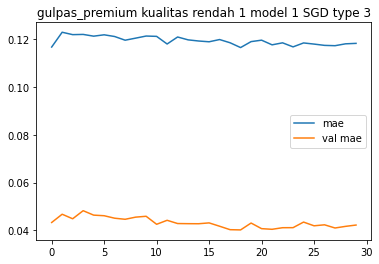

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('gulpas_premium kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
208.56442 1.3535718 258.28932420833814


,actual,prediction
0,15450,16203.128906
1,15450,16191.020508
2,15450,16173.697266
3,15450,16156.246094
4,15450,16131.329102
...,...,...
229,15550,15793.045898
230,15450,15763.393555
231,15850,15767.104492
232,15350,15740.137695


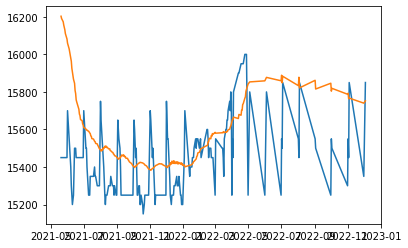

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_gulpas_premium_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_gulpas_premium_2 = pd.DataFrame()
# data_new_gulpas_premium1['date'] = date_test
data_new_gulpas_premium_2['actual'] = x_test
data_new_gulpas_premium_2['prediction'] = data_result_2
data_new_gulpas_premium_2.to_csv('gulpas_premium_model1_sgd_type3')

plt.plot(y_test, data_new_gulpas_premium_2.actual)
plt.plot(y_test, data_new_gulpas_premium_2.prediction)
data_new_gulpas_premium_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_4 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_5 (LSTM)               (None, 20)                3600      
                                                                 
 dense_4 (Dense)             (None, 64)                1344      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 6s 66ms/step - loss: 0.2607 - mae: 0.4327 - mape: 85.4878 - val_loss: 0.0071 - val_mae: 0.0767 - val_mape: 56.0802
Epoch 2/30
44/44 [==============================] - 2s 47ms/step - loss: 0.1687 - mae: 0.3232 - mape: 64.6947 - val_loss: 0.0027 - val_mae: 0.0358 - val_mape: 57.1324
Epoch 3/30
44/44 [==============================] - 3s 55ms/step - loss: 0.0814 - mae: 0.2177 - mape: 69.7006 - val_loss: 0.0226 - val_mae: 0.1434 - val_mape: 165.6008
Epoch 4/30
44/44 [==============================] - 2s 44ms/step - loss: 0.0629 - mae: 0.2090 - mape: 86.2585 - val_loss: 0.0254 - val_mae: 0.1528 - val_mape: 174.6693
Epoch 5/30
44/44 [==============================] - 2s 48ms/step - loss: 0.0631 - mae: 0.2111 - mape: 88.5838 - val_loss: 0.0230 - val_mae: 0.1447 - val_mape: 166.9374
Epoch 6/30
44/44 [==============================] - 2s 47ms/step - loss: 0.0625 - mae: 0.2058 - mape: 84.1180 - val_loss: 0.0255 - val_mae: 0.1530 - val_mape: 174

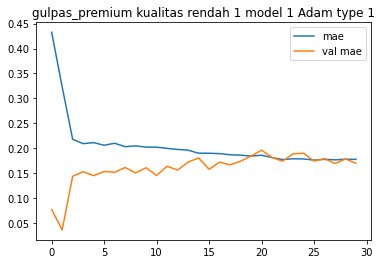

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('gulpas_premium kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
394.76334 2.5679417 432.3277113486944


,actual,prediction
0,15450,16045.737305
1,15450,16033.139648
2,15450,16038.056641
3,15450,16028.493164
4,15450,16024.949219
...,...,...
229,15550,16160.805664
230,15450,16090.982422
231,15850,16139.928711
232,15350,16069.021484


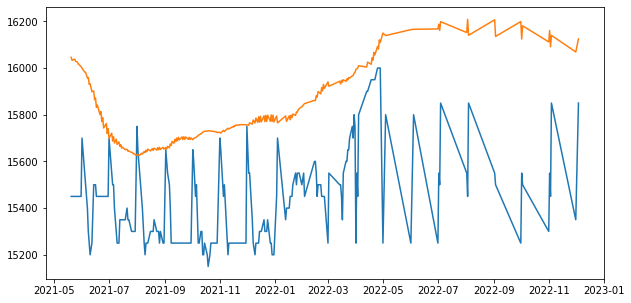

In [ ]:
prediction_a = forecast_predict(model_a, test_gulpas_premium_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_gulpas_premium_a = pd.DataFrame()
# data_new_gulpas_premium1['date'] = date_test
data_new_gulpas_premium_a['actual'] = x_test
data_new_gulpas_premium_a['prediction'] = data_result_a
data_new_gulpas_premium_a.to_csv('gulpas_premium_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_gulpas_premium_a.actual)
plt.plot(y_test, data_new_gulpas_premium_a.prediction)
data_new_gulpas_premium_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0216 - mae: 0.0919 - mape: 92659.6250 - val_loss: 0.0130 - val_mae: 0.1035 - val_mape: 128.1600
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0201 - mae: 0.0869 - mape: 65281.9258 - val_loss: 0.0130 - val_mae: 0.1026 - val_mape: 127.7477
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0203 - mae: 0.0847 - mape: 58478.6289 - val_loss: 0.0074 - val_mae: 0.0718 - val_mape: 97.1312
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0197 - mae: 0.0845 - mape: 54378.0000 - val_loss: 0.0047 - val_mae: 0.0546 - val_mape: 77.8670
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0197 - mae: 0.0837 - mape: 59859.8008 - val_loss: 0.0052 - val_mae: 0.0576 - val_mape: 81.9621
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0188 - mae: 0.0801 - mape: 54512.6133 - val_loss: 0.0050 - val_mae:

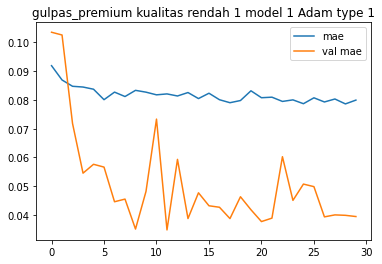

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('gulpas_premium kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
600.5541 3.896863 697.8883103692166


,actual,prediction
0,15450,16876.892578
1,15450,16926.621094
2,15450,16872.451172
3,15450,16937.103516
4,15450,16852.814453
...,...,...
229,15550,16703.519531
230,15450,16631.851562
231,15850,16691.347656
232,15350,16614.005859


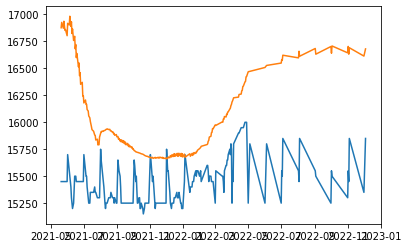

In [ ]:
prediction_a1 = forecast_predict(model_a, test_gulpas_premium_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_gulpas_premium_a1 = pd.DataFrame()
data_new_gulpas_premium_a1['actual'] = x_test
data_new_gulpas_premium_a1['prediction'] = data_result_a1
data_new_gulpas_premium_a1.to_csv('gulpas_premium_model1_adam_type2.csv')

plt.plot(y_test, data_new_gulpas_premium_a1.actual)
plt.plot(y_test, data_new_gulpas_premium_a1.prediction)
data_new_gulpas_premium_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0273 - mae: 0.0979 - mape: 70.4138 - val_loss: 0.0023 - val_mae: 0.0357 - val_mape: 48.7524
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0273 - mae: 0.0972 - mape: 67.3895 - val_loss: 0.0023 - val_mae: 0.0361 - val_mape: 48.1948
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0273 - mae: 0.0979 - mape: 69.2783 - val_loss: 0.0023 - val_mae: 0.0362 - val_mape: 48.1428
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0273 - mae: 0.0964 - mape: 64.6258 - val_loss: 0.0023 - val_mae: 0.0353 - val_mape: 48.3261
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0273 - mae: 0.0968 - mape: 66.0735 - val_loss: 0.0023 - val_mae: 0.0348 - val_mape: 49.1545
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0274 - mae: 0.0986 - mape: 70.5211 - val_loss: 0.0023 - val_mae: 0.0346 - val_mape: 49.870

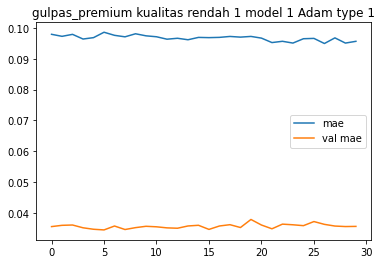

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('gulpas_premium kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
213.60988 1.3823398 303.83572607167184


,actual,prediction
0,15450,16001.256836
1,15450,15971.458008
2,15450,16008.731445
3,15450,15991.313477
4,15450,16020.408203
...,...,...
229,15550,16069.909180
230,15450,16000.309570
231,15850,16034.321289
232,15350,15961.476562


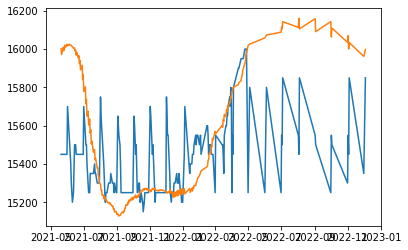

In [ ]:
prediction_a2 = forecast_predict(model_a, test_gulpas_premium_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_gulpas_premium_a2 = pd.DataFrame()
# data_new_gulpas_premium1['date'] = date_test
data_new_gulpas_premium_a2['actual'] = x_test
data_new_gulpas_premium_a2['prediction'] = data_result_a2
data_new_gulpas_premium_a2.to_csv('gulpas_premium_model1_adam_type3.csv')

plt.plot(y_test, data_new_gulpas_premium_a2.actual)
plt.plot(y_test, data_new_gulpas_premium_a2.prediction)
data_new_gulpas_premium_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 47ms/step - loss: 0.2231 - mae: 0.3820 - mape: 77.3676 - val_loss: 0.0030 - val_mae: 0.0384 - val_mape: 60.2178
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0738 - mae: 0.2076 - mape: 81.9839 - val_loss: 0.0104 - val_mae: 0.0915 - val_mape: 115.3103
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0639 - mae: 0.2065 - mape: 82.5297 - val_loss: 0.0177 - val_mae: 0.1250 - val_mape: 147.7663
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0640 - mae: 0.2033 - mape: 87.2669 - val_loss: 0.0147 - val_mae: 0.1125 - val_mape: 135.6809
Epoch 5/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0615 - mae: 0.2050 - mape: 86.1326 - val_loss: 0.0158 - val_mae: 0.1172 - val_mape: 140.3825
Epoch 6/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0606 - mae: 0.2017 - mape: 84.8614 - val_loss: 0.0195 - val_mae: 0.1318 - val_mape: 15

17/17 [==============================] - 0s 7ms/step - loss: 0.0616 - mae: 0.1994 - mape: 79.7025


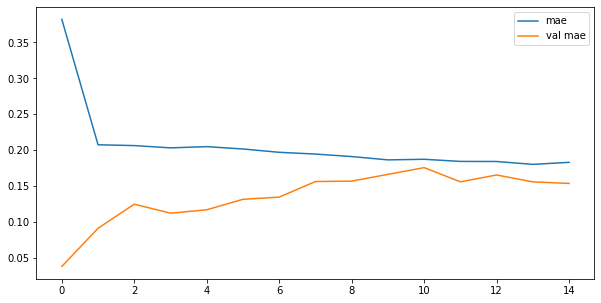

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_gulpas_premium_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_gulpas_premium1 = pd.DataFrame()
data_new_gulpas_premium1['actual'] = x_test
data_new_gulpas_premium1['prediction'] = data_result1
data_new_gulpas_premium1.to_csv('gulpas_premium_model2_adam_type1.csv')

data_new_gulpas_premium1

131/131 [==============================] - 2s 7ms/step
410.8485 2.6733057 449.2650074009771


,actual,prediction
0,15450,16119.836914
1,15450,16113.837891
2,15450,16122.626953
3,15450,16112.743164
4,15450,16117.742188
...,...,...
229,15550,16145.235352
230,15450,16124.426758
231,15850,16126.460938
232,15350,16103.722656


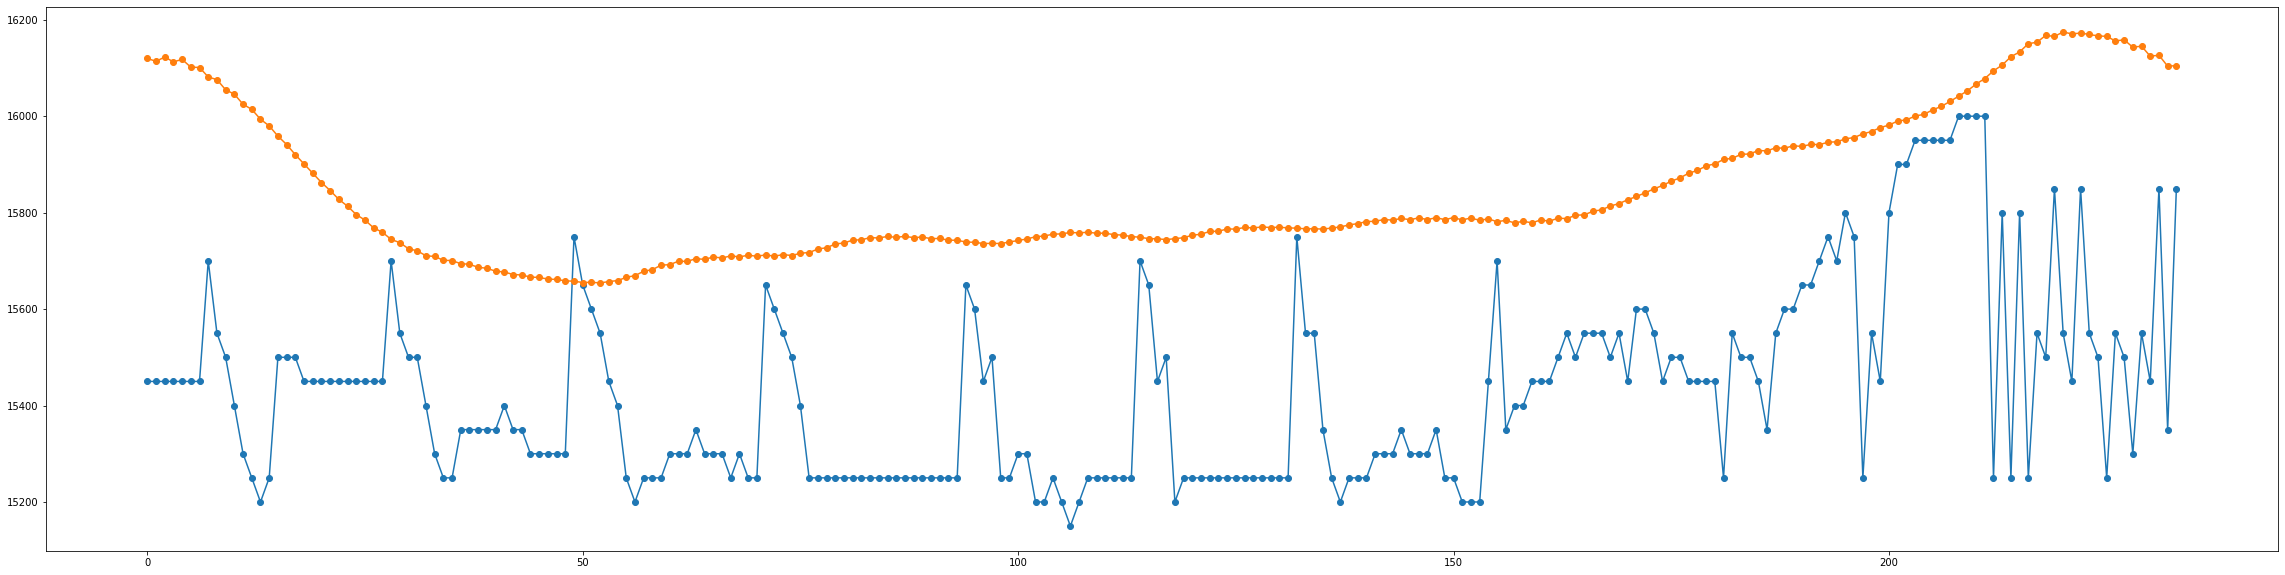

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_gulpas_premium1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_gulpas_premium1['prediction'], '-o')

#### Type 2

In [12]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 23s 10ms/step - loss: 0.0267 - mae: 0.1019 - mape: 99607.0625 - val_loss: 0.0054 - val_mae: 0.0599 - val_mape: 83.8284
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0234 - mae: 0.0953 - mape: 95545.5938 - val_loss: 0.0036 - val_mae: 0.0450 - val_mape: 68.0883
Epoch 3/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0218 - mae: 0.0918 - mape: 102696.7812 - val_loss: 0.0055 - val_mae: 0.0603 - val_mape: 84.7075
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0216 - mae: 0.0931 - mape: 26098.4043 - val_loss: 0.0021 - val_mae: 0.0335 - val_mape: 47.8059
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0221 - mae: 0.0918 - mape: 77883.9375 - val_loss: 0.0074 - val_mae: 0.0743 - val_mape: 98.4836
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0207 - mae: 0.0871 - mape: 63008.4141 - val_loss: 0.0041 - val_ma

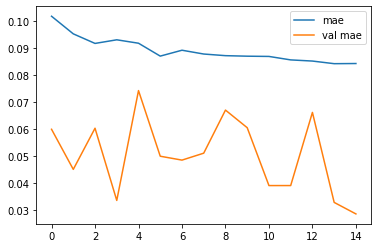

In [13]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
210.81819 1.3657069 287.63794245109597


,actual,prediction
0,15450,16143.919922
1,15450,16162.313477
2,15450,16191.127930
3,15450,16193.186523
4,15450,16218.357422
...,...,...
229,15550,16011.263672
230,15450,16036.446289
231,15850,15951.112305
232,15350,15976.824219


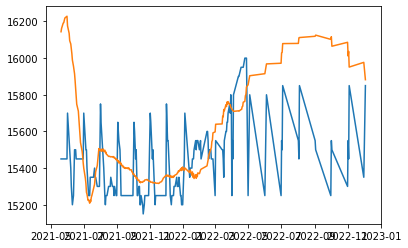

In [17]:
prediction1_1 = forecast_predict(model1, test_gulpas_premium_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_gulpas_premium1_1 = pd.DataFrame()
data_new_gulpas_premium1_1['actual'] = x_test
data_new_gulpas_premium1_1['prediction'] = data_result1_1
data_new_gulpas_premium1_1.to_csv('gulpas_premium_model2_adam_type2.csv')

plt.plot(y_test, data_new_gulpas_premium1_1.actual)
plt.plot(y_test, data_new_gulpas_premium1_1.prediction)
data_new_gulpas_premium1_1

#### Type 3

In [18]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0285 - mae: 0.1094 - mape: 82.7003 - val_loss: 0.0018 - val_mae: 0.0268 - val_mape: 43.8379
Epoch 2/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0277 - mae: 0.1029 - mape: 69.9156 - val_loss: 0.0017 - val_mae: 0.0263 - val_mape: 42.8605
Epoch 3/15
84/84 [==============================] - 2s 23ms/step - loss: 0.0278 - mae: 0.1021 - mape: 69.3836 - val_loss: 0.0016 - val_mae: 0.0266 - val_mape: 40.8542
Epoch 4/15
84/84 [==============================] - 3s 30ms/step - loss: 0.0273 - mae: 0.1006 - mape: 69.3053 - val_loss: 0.0021 - val_mae: 0.0328 - val_mape: 50.3967
Epoch 5/15
84/84 [==============================] - 2s 23ms/step - loss: 0.0271 - mae: 0.1002 - mape: 66.7088 - val_loss: 0.0016 - val_mae: 0.0279 - val_mape: 40.1236
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0274 - mae: 0.1013 - mape: 69.8643 - val_loss: 0.0017 - val_mae: 0.0282 - val_mape: 41.754

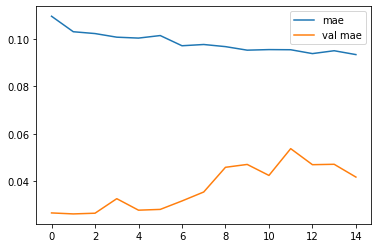

In [19]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
358.9206 2.331431 465.9235955336454


,actual,prediction
0,15450,16513.724609
1,15450,16533.652344
2,15450,16579.228516
3,15450,16580.296875
4,15450,16602.042969
...,...,...
229,15550,16318.574219
230,15450,16309.070312
231,15850,16223.413086
232,15350,16215.638672


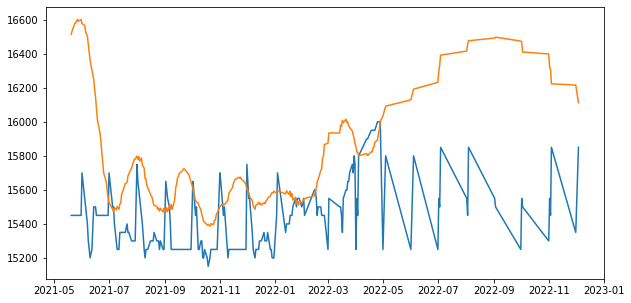

In [20]:
prediction1_2 = forecast_predict(model1, test_gulpas_premium_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_gulpas_premium1_2 = pd.DataFrame()
data_new_gulpas_premium1_2['actual'] = x_test
data_new_gulpas_premium1_2['prediction'] = data_result1_2
data_new_gulpas_premium1_2.to_csv('gulpas_premium_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_premium1_2.actual)
plt.plot(y_test, data_new_gulpas_premium1_2.prediction)

data_new_gulpas_premium1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_a = forecast_predict(model1_a, test_gulpas_premium_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_gulpas_premium1_a = pd.DataFrame()
data_new_gulpas_premium1_a['actual'] = x_test
data_new_gulpas_premium1_a['prediction'] = data_result1_a
data_new_gulpas_premium1_a.to_csv('gulpas_premium_model2_sgd_type1.csv')


plt.plot(y_test, data_new_gulpas_premium1_a.actual)
plt.plot(y_test, data_new_gulpas_premium1_a.prediction)

data_new_gulpas_premium1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0450 - mae: 0.1568 - mape: 283897.9688 - val_loss: 0.0450 - val_mae: 0.2073 - val_mape: 227.3786
Epoch 2/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0383 - mae: 0.1325 - mape: 245170.1094 - val_loss: 0.0394 - val_mae: 0.1932 - val_mape: 213.7320
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0357 - mae: 0.1280 - mape: 163083.3594 - val_loss: 0.0354 - val_mae: 0.1827 - val_mape: 203.6826
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0320 - mae: 0.1187 - mape: 204467.4375 - val_loss: 0.0338 - val_mae: 0.1780 - val_mape: 199.1898
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0298 - mae: 0.1157 - mape: 206383.8906 - val_loss: 0.0275 - val_mae: 0.1595 - val_mape: 181.3929
Epoch 6/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0286 - mae: 0.1103 - mape: 146618.2656 - val_loss: 0.0208 -

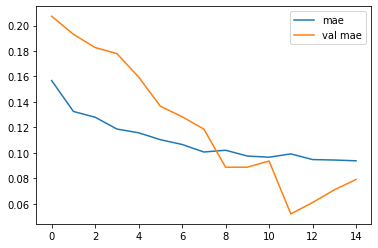

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
285.3498 1.8567815 336.11889869880866


,actual,prediction
0,15450,16241.339844
1,15450,16229.569336
2,15450,16224.915039
3,15450,16209.134766
4,15450,16199.438477
...,...,...
229,15550,15873.911133
230,15450,15853.416992
231,15850,15857.344727
232,15350,15837.178711


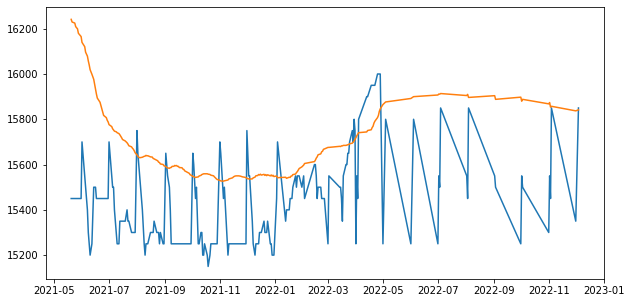

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_gulpas_premium_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_gulpas_premium1_a1 = pd.DataFrame()
data_new_gulpas_premium1_a1['actual'] = x_test
data_new_gulpas_premium1_a1['prediction'] = data_result1_a1
data_new_gulpas_premium1_a1.to_csv('gulpas_premium_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_premium1_a1.actual)
plt.plot(y_test, data_new_gulpas_premium1_a1.prediction)
data_new_gulpas_premium1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0357 - mae: 0.1373 - mape: 114.0111 - val_loss: 0.0060 - val_mae: 0.0646 - val_mape: 88.9697
Epoch 2/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0352 - mae: 0.1307 - mape: 101.5016 - val_loss: 0.0054 - val_mae: 0.0598 - val_mape: 83.9958
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0350 - mae: 0.1270 - mape: 94.2923 - val_loss: 0.0048 - val_mae: 0.0553 - val_mape: 79.3278
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0349 - mae: 0.1266 - mape: 93.1258 - val_loss: 0.0048 - val_mae: 0.0554 - val_mape: 79.4618
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0348 - mae: 0.1280 - mape: 95.4456 - val_loss: 0.0049 - val_mae: 0.0559 - val_mape: 79.9854
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0347 - mae: 0.1265 - mape: 92.2081 - val_loss: 0.0044 - val_mae: 0.0521 - val_mape: 75.9

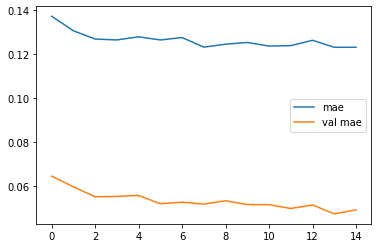

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 9ms/step
236.6431 1.5371574 291.3730292726147


,actual,prediction
0,15450,16243.411133
1,15450,16229.940430
2,15450,16224.970703
3,15450,16207.092773
4,15450,16195.512695
...,...,...
229,15550,15820.355469
230,15450,15797.860352
231,15850,15802.008789
232,15350,15779.844727


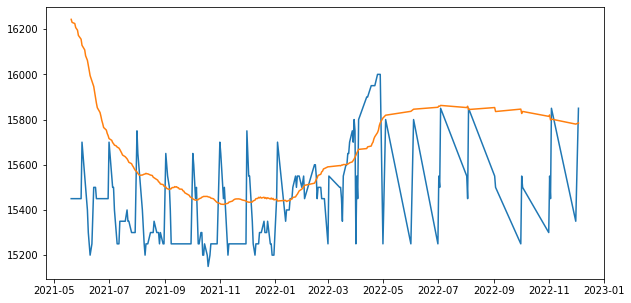

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_gulpas_premium_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_gulpas_premium1_a2 = pd.DataFrame()
data_new_gulpas_premium1_a2['actual'] = x_test
data_new_gulpas_premium1_a2['prediction'] = data_result1_a2
data_new_gulpas_premium1_a2.to_csv('gulpas_premium_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_premium1_a2.actual)
plt.plot(y_test, data_new_gulpas_premium1_a2.prediction)

data_new_gulpas_premium1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 8)          0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 14)          1288      
                                                                 
 dropout_1 (Dropout)         (None, None, 14)          0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                20224     
                                                                 
 dense_15 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 6s 31ms/step - loss: 0.2810 - mae: 0.4523 - mape: 89.5505 - val_loss: 0.0068 - val_mae: 0.0752 - val_mape: 55.4041
Epoch 2/50
44/44 [==============================] - 1s 15ms/step - loss: 0.2208 - mae: 0.3872 - mape: 73.7645 - val_loss: 0.0020 - val_mae: 0.0359 - val_mape: 46.2997
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.1768 - mae: 0.3375 - mape: 67.4983 - val_loss: 0.0047 - val_mae: 0.0549 - val_mape: 78.1948
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.1452 - mae: 0.3002 - mape: 67.5857 - val_loss: 0.0119 - val_mae: 0.0995 - val_mape: 122.9121
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.1231 - mae: 0.2729 - mape: 69.3551 - val_loss: 0.0223 - val_mae: 0.1424 - val_mape: 164.3484
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.1074 - mae: 0.2498 - mape: 71.0018 - val_loss: 0.0330 - val_mae: 0.1761 - val_mape: 196.

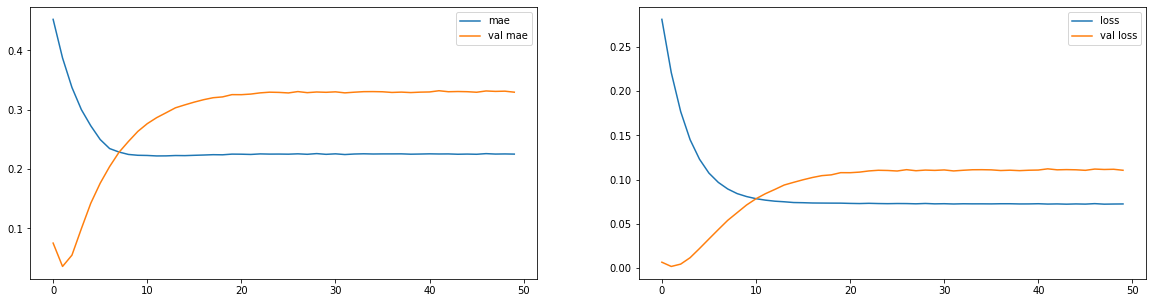

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
919.13873 5.973488 940.0703431126843


,actual,prediction
0,15450,16399.902344
1,15450,16402.669922
2,15450,16396.529297
3,15450,16396.791016
4,15450,16395.744141
...,...,...
229,15550,16359.580078
230,15450,16358.839844
231,15850,16360.248047
232,15350,16357.181641


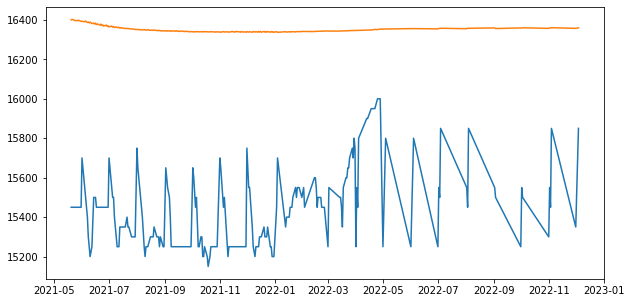

In [ ]:
prediction2 = forecast_predict(model2, test_gulpas_premium_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_gulpas_premium2 = pd.DataFrame()
data_new_gulpas_premium2['actual'] = x_test
data_new_gulpas_premium2['prediction'] = data_result2
data_new_gulpas_premium2.to_csv('gulpas_premium_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_premium2.actual)
plt.plot(y_test, data_new_gulpas_premium2.prediction)
data_new_gulpas_premium2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0535 - mae: 0.1774 - mape: 358292.4688 - val_loss: 0.0467 - val_mae: 0.2113 - val_mape: 230.9753
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0461 - mae: 0.1504 - mape: 256803.2500 - val_loss: 0.0436 - val_mae: 0.2039 - val_mape: 223.8523
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0446 - mae: 0.1478 - mape: 436064.3438 - val_loss: 0.0445 - val_mae: 0.2061 - val_mape: 225.8866
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0437 - mae: 0.1433 - mape: 210845.7656 - val_loss: 0.0436 - val_mae: 0.2041 - val_mape: 223.9553
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0421 - mae: 0.1412 - mape: 246788.9688 - val_loss: 0.0490 - val_mae: 0.2168 - val_mape: 236.2767
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0415 - mae: 0.1398 - mape: 327238.9375 - val_loss: 0.0448 -

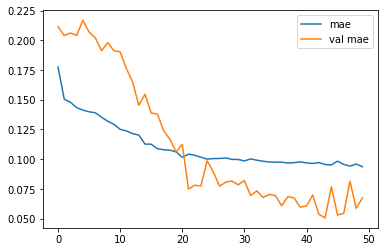

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_gulpas_premium_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_gulpas_premium2_1 = pd.DataFrame()
data_new_gulpas_premium2_1['actual'] = x_test
data_new_gulpas_premium2_1['prediction'] = data_result2_1
data_new_gulpas_premium2_1.to_csv('gulpas_premium_model3_sgd_type2.csv')

data_new_gulpas_premium2

199/199 [==============================] - 1s 3ms/step
249.78609 1.622403 305.5164684595578


,actual,prediction
0,15450,16399.902344
1,15450,16402.669922
2,15450,16396.529297
3,15450,16396.791016
4,15450,16395.744141
...,...,...
229,15550,16359.580078
230,15450,16358.839844
231,15850,16360.248047
232,15350,16357.181641


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0363 - mae: 0.1374 - mape: 111.4835 - val_loss: 0.0048 - val_mae: 0.0557 - val_mape: 78.9987
Epoch 2/50
84/84 [==============================] - 1s 10ms/step - loss: 0.0359 - mae: 0.1306 - mape: 100.0273 - val_loss: 0.0044 - val_mae: 0.0523 - val_mape: 75.4533
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0353 - mae: 0.1285 - mape: 96.5916 - val_loss: 0.0039 - val_mae: 0.0482 - val_mape: 71.1080
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0362 - mae: 0.1278 - mape: 94.4977 - val_loss: 0.0039 - val_mae: 0.0484 - val_mape: 71.3384
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0358 - mae: 0.1292 - mape: 96.4532 - val_loss: 0.0042 - val_mae: 0.0512 - val_mape: 74.2864
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0352 - mae: 0.1290 - mape: 97.2876 - val_loss: 0.0039 - val_mae: 0.0485 - val_mape: 71.4

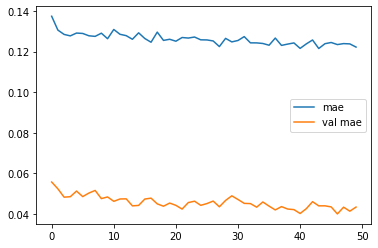

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_gulpas_premium_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_gulpas_premium2_2 = pd.DataFrame()
data_new_gulpas_premium2_2['actual'] = x_test
data_new_gulpas_premium2_2['prediction'] = data_result2_2
data_new_gulpas_premium2_2.to_csv('gulpas_premium_model3_sgd-type3.csv')

data_new_gulpas_premium2_2

181/181 [==============================] - 1s 4ms/step
218.57121 1.4163226 277.3693949411146


,actual,prediction
0,15450,16224.745117
1,15450,16221.323242
2,15450,16197.849609
3,15450,16242.921875
4,15450,16166.328125
...,...,...
229,15550,15800.143555
230,15450,15721.970703
231,15850,15767.934570
232,15350,15758.852539


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_14 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_2 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_15 (LSTM)              (None, 80)                33600     
                                                                 
 dense_18 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 45ms/step - loss: 0.2792 - mae: 0.4504 - mape: 89.3179 - val_loss: 0.0081 - val_mae: 0.0811 - val_mape: 57.0496
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.1551 - mae: 0.2978 - mape: 64.3783 - val_loss: 0.0102 - val_mae: 0.0911 - val_mape: 113.9133
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0879 - mae: 0.2426 - mape: 99.3116 - val_loss: 0.0075 - val_mae: 0.0751 - val_mape: 98.3486
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0848 - mae: 0.2396 - mape: 89.8531 - val_loss: 0.0097 - val_mae: 0.0882 - val_mape: 111.4332
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0791 - mae: 0.2301 - mape: 83.1883 - val_loss: 0.0168 - val_mae: 0.1221 - val_mape: 144.1829
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0746 - mae: 0.2290 - mape: 92.1773 - val_loss: 0.0184 - val_mae: 0.1282 - val_mape: 150

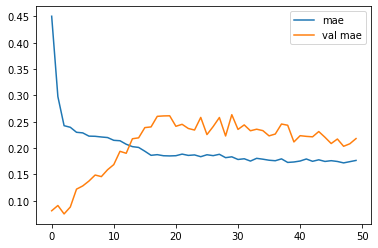

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_gulpas_premium_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_gulpas_premium2_a = pd.DataFrame()
data_new_gulpas_premium2_a['actual'] = x_test
data_new_gulpas_premium2_a['prediction'] = data_result2_a
data_new_gulpas_premium2_a.to_csv('gulpas_premium_model3_adam-type1.csv')

data_new_gulpas_premium2_a

131/131 [==============================] - 1s 6ms/step
417.11285 2.713698 452.960728844124


,actual,prediction
0,15450,16090.343750
1,15450,16125.768555
2,15450,16097.279297
3,15450,16103.516602
4,15450,16077.131836
...,...,...
229,15550,16115.094727
230,15450,16138.041016
231,15850,16155.145508
232,15350,16147.967773


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0185 - mae: 0.0767 - mape: 54565.6094 - val_loss: 0.0051 - val_mae: 0.0626 - val_mape: 50.5178
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0188 - mae: 0.0786 - mape: 40502.1094 - val_loss: 0.0051 - val_mae: 0.0602 - val_mape: 45.6713
Epoch 3/50
718/718 [==============================] - 7s 9ms/step - loss: 0.0184 - mae: 0.0778 - mape: 54183.2656 - val_loss: 0.0056 - val_mae: 0.0668 - val_mape: 48.8190
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0182 - mae: 0.0777 - mape: 45069.1758 - val_loss: 0.0049 - val_mae: 0.0608 - val_mape: 45.5925
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0188 - mae: 0.0790 - mape: 45418.7969 - val_loss: 0.0043 - val_mae: 0.0570 - val_mape: 44.6795
Epoch 6/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0185 - mae: 0.0780 - mape: 48006.7188 - val_loss: 0.0049 - val_mae: 0

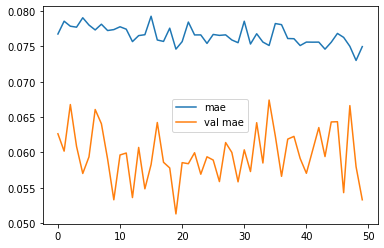

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
418.58472 2.7088468 535.4146173761042


,actual,prediction
0,15450,16581.634766
1,15450,16653.451172
2,15450,16667.845703
3,15450,16717.417969
4,15450,16594.681641
...,...,...
229,15550,16072.681641
230,15450,16134.893555
231,15850,16209.495117
232,15350,16188.294922


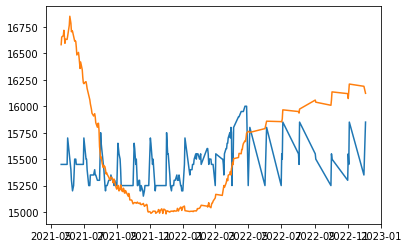

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_gulpas_premium_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_gulpas_premium2_a1 = pd.DataFrame()
data_new_gulpas_premium2_a1['actual'] = x_test
data_new_gulpas_premium2_a1['prediction'] = data_result2_a1
data_new_gulpas_premium2_a1.to_csv('gulpas_premium_model3_adam-type2.csv')

plt.plot(y_test, data_new_gulpas_premium2_a1.actual)
plt.plot(y_test, data_new_gulpas_premium2_a1.prediction)
data_new_gulpas_premium2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

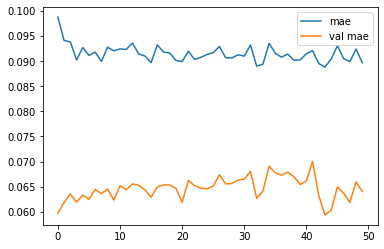

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 7ms/step
342.18704 2.2150164 391.7451339838186


,actual,prediction
0,15450,15997.869141
1,15450,16079.944336
2,15450,15957.173828
3,15450,16108.740234
4,15450,16028.880859
...,...,...
229,15550,16245.120117
230,15450,16238.533203
231,15850,16178.351562
232,15350,16252.578125


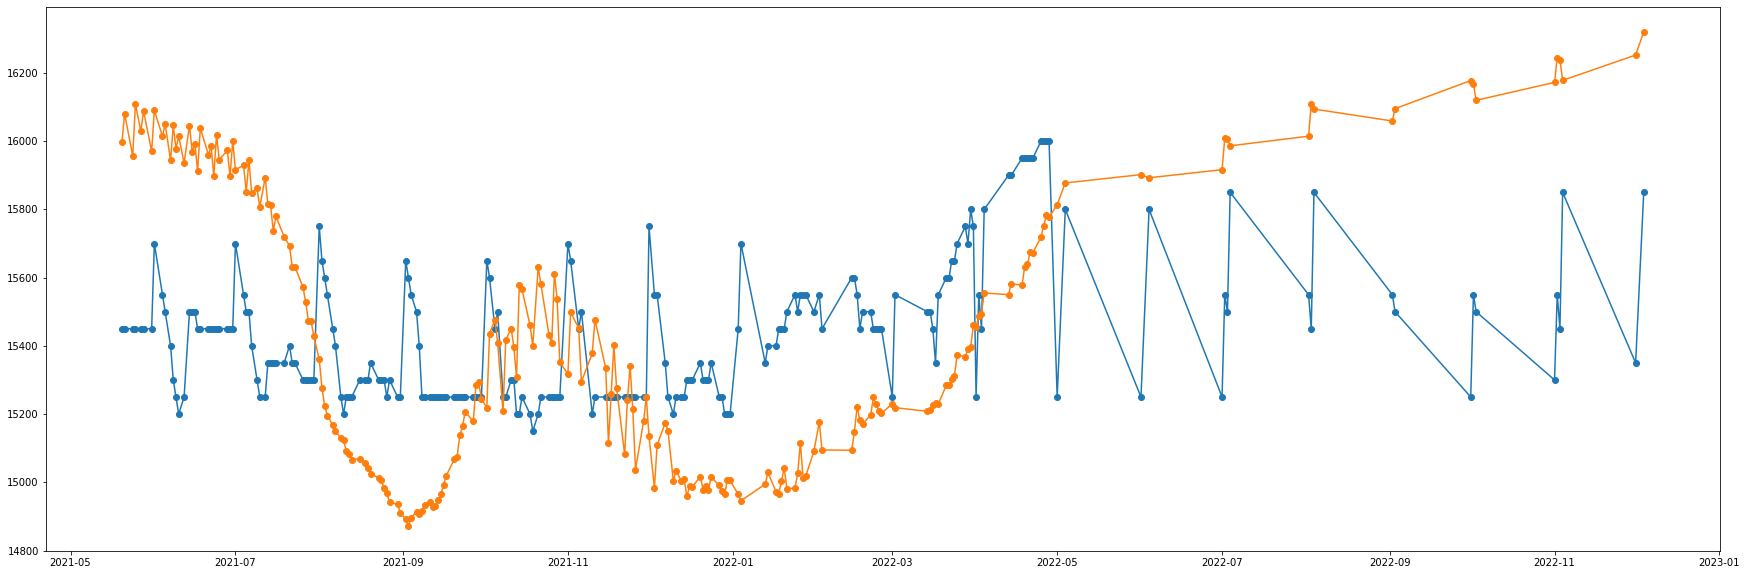

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_gulpas_premium_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_gulpas_premium2_a2 = pd.DataFrame()
data_new_gulpas_premium2_a2['actual'] = x_test
data_new_gulpas_premium2_a2['prediction'] = data_result2_a2
data_new_gulpas_premium2_a2.to_csv('gulpas_premium_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_gulpas_premium2_a2.actual, '-o')
plt.plot(y_test,data_new_gulpas_premium2_a2.prediction, '-o')
data_new_gulpas_premium2_a2